# This is a environment to test, prototype, and develop CCBA Library.

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '/Users/Kwat/binf/ccba')
import ccbal

%matplotlib inline
%config InlineBackend.figure_formats = {'svg', }

================ Computational Cancer Biology Analysis Library ================

<11:01:05.468212> Checking dependencies ...
<11:01:05.470700> Using the following packages:
<11:01:05.472434> 	matplotlib v1.5.1
<11:01:05.472452> 	numpy v1.10.4
<11:01:05.472461> 	pandas v0.18.0
<11:01:05.472481> 	rpy2 v2.7.9
<11:01:05.472489> 	scikit-learn v0.17.1
<11:01:05.472496> 	scipy v0.17.0
<11:01:05.472504> 	seaborn v0.7.0


# Make test data

In [2]:
FONT1 = ccbal.visualize.FONT1
FONT2 = ccbal.visualize.FONT2
FONT3 = ccbal.visualize.FONT3
font1=FONT1
font2=FONT2
font3=FONT3

CMAP_CONTINUOUS = ccbal.visualize.CMAP_CONTINUOUS
CMAP_CATEGORICAL = ccbal.visualize.CMAP_CATEGORICAL
CMAP_BINARY = ccbal.visualize.CMAP_BINARY

In [88]:
nrow = 10
ncol = 10

df = pd.DataFrame(np.random.random((nrow, ncol)),
                  index=['SAMPLE {}'.format(i) for i in range(nrow)])
annot = pd.Series(np.random.rand(nrow), name='Score', index=['SAMPLE {}'.format(i) for i in range(nrow)])

ref_type = 'categorical'

if ref_type == 'continuous':
    ref = pd.Series(np.random.rand(ncol), name='Continuous Reference')
elif ref_type == 'categorical':
    n_category = 5
    categorical_vector = np.random.random_integers(0, n_category, ncol)
    ref = pd.Series(categorical_vector, name='Categorical Reference')
    ref_labels = [str(i) for i in categorical_vector]
elif ref_type == 'binary':
    binary_vector = np.random.random_integers(0, 1, ncol)
    ref = pd.Series(binary_vector, name='Binary Reference')
    ref_labels = [str(i) for i in binary_vector]

title = 'Title'

In [89]:
def normalize_df_by_mean(df, inplace=False):
    for i, (idx, s) in enumerate(df.iterrows()):
        mean = s.mean()
        std = s.std()
        for j, v in enumerate(s):
            df.iloc[i, j] = (v - mean) / std

Sorted ref index: Int64Index([8, 7, 6, 5, 2, 0, 9, 3, 1, 4], dtype='int64')
Sorted ref labels: ['0', '1', '1', '1', '2', '2', '3', '3', '4', '4']
Sorted df columns: Int64Index([8, 7, 6, 5, 2, 0, 9, 3, 1, 4], dtype='int64')
boundaries: [0, 2, 4, 6, 9, 10]
label_horizontal_positions: [1.0, 3.0, 5.0, 7.5, 9.5]
0 1.0
1 3.0
2 5.0
3 7.5
4 9.5


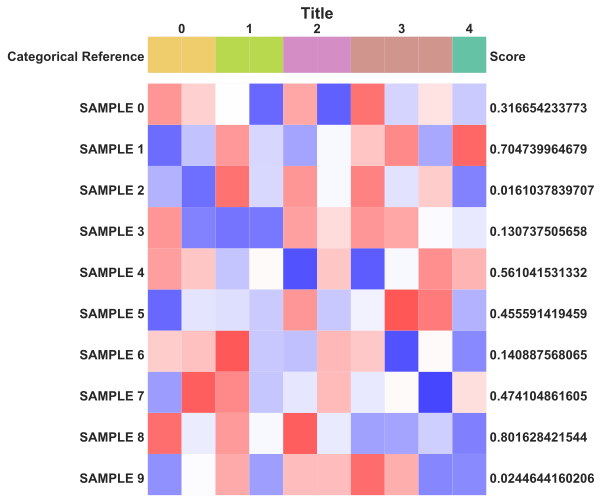

In [90]:
# Set heatmap parameters for ref
if ref_type == 'binary':
    ref_cmap = CMAP_BINARY
    ref_min, ref_max = 0, 1
elif ref_type == 'categorical':
    ref_cmap = CMAP_CATEGORICAL
    ref_min, ref_max = 0, np.unique(ref.values).size
    assert np.unique(ref_labels).size == np.unique(ref.values).size
elif ref_type == 'continuous':
    ref_cmap = CMAP_CONTINUOUS
    ref = (ref - np.mean(ref)) / np.std(ref)
    ref_min, ref_max = -2.5, 2.5
else:
    raise ValueError('Unknown ref_type {}.'.format(ref_type))

# Set heapmap parameters for df and normalize df
if np.unique(df).size == 2:
    df_cmap = CMAP_BINARY
    df_min, df_max = 0, 1
    # TODO:
    df += 0.25
else:
    df_cmap = CMAP_CONTINUOUS
    df_min, df_max = -2.5, 2.5
    # TODO: make a normalization function
    normalize_df_by_mean(df)

# Set figure size
ncol, nrow = df.shape
if nrow <= 25:
    fig_height = nrow / 1.5
else:
    fig_height = nrow / 2.5
if ncol <= 25:
    fig_width = 5
else:
    fig_width = 7
figure_size = (fig_width, fig_height)

# Sort ref
ref.sort_values(ascending=False, inplace=True)
print('Sorted ref index: {}'.format(ref.index))
ref_labels = sorted(ref_labels)
print('Sorted ref labels: {}'.format(ref_labels))
df = df.reindex_axis(ref.index, axis=1)
print('Sorted df columns: {}'.format(df.columns))

# Get labels' horizontal positions for binary and categorical
if ref_labels and ref_type in ('binary', 'categorical'):
    # Get boundaries
    boundaries = [0]
    prev_v = ref.iloc[0]
    for i, v in enumerate(ref.iloc[1:]):
        if prev_v != v:
            boundaries.append(i + 1)
        prev_v = v
    boundaries.append(ncol)
    print('boundaries: {}'.format(boundaries))

    # Get label horizontal positions
    label_horizontal_positions = []
    prev_b = 0
    for b in boundaries[1:]:
        label_horizontal_positions.append(b - (b - prev_b) / 2)
        prev_b = b
    print('label_horizontal_positions: {}'.format(label_horizontal_positions))


# Initialize figure
fig = plt.figure(figsize=figure_size)

# Plot ref
ax1 = plt.subplot2grid((nrow, 1), (0, 0))
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, robust=True, center=None, mask=None,
            square=False, cmap=ref_cmap, linewidth=0.0, linecolor='b',
            annot=False, fmt=None, annot_kws={}, xticklabels=False,
            yticklabels=[], cbar=False)
ax1.text(ncol / 2, 1.5, title, fontsize=16, horizontalalignment='center', fontweight='bold')
ax1.text(-0.1, 0.33, 
         ref.name, fontsize=13, horizontalalignment='right', fontweight='bold')
ax1.text(ncol + 0.1, 0.33,
         annot.name, fontsize=13, horizontalalignment='left', fontweight='bold')

if ref_labels and ref_type in ('binary', 'categorical'):
    unique_ref_labels = np.unique(ref_labels)
    for i, pos in enumerate(label_horizontal_positions):
        print(i, pos)
        ax1.text(pos, 1.1, unique_ref_labels[i],
                 fontsize=13, horizontalalignment='center', fontweight='bold')

# Plot dataframe
ax2 = plt.subplot2grid((nrow, 1), (0, 1), rowspan=nrow)
sns.heatmap(df, vmin=df_min, vmax=df_max, robust=True, center=None, mask=None,
            square=False, cmap=df_cmap, linewidth=0.0, linecolor='b',
            annot=False, fmt=None, annot_kws={}, xticklabels=False,
            yticklabels=[], cbar=False)

for i, idx in enumerate(df.index):
    ax2.text(-0.1, nrow - i - 0.7, idx, fontsize=13, horizontalalignment='right', fontweight='bold')
    ax2.text(ncol + 0.1, nrow - i - 0.7, annot[i], fontsize=13, fontweight='bold')

fig.tight_layout()
plt.show(fig)

# NMF

In [ ]:
nmf_result = ccbal.analyze.nmf(df, [3], plot=True)

In [ ]:
ns, runtimes = ccbal.support.runtime(ccbal.information.information_coefficient, n_range=range(10))

In [ ]:
from scipy.stats import pearsonr
ns, runtimes = ccbal.support.runtime(pearsonr, n_range=range(10))

In [ ]:
# make_heatmap_panel is in the ccba/library/ccba.py
# make_heatmap_panel calls plot_heatmap_panel, which is in the ccba/library/visualize.py
# make_heatmap_panel computes IC of each df's row and the ref (target).
# In the future, we can add other computation within this function so it can compute P-Val and FDR as well.
make_heatmap_panel(df, ref, ['IC', 'P-Val'])

# XXX

In [ ]:
# Feature selection test with real data for IC, CMI diff, and CMI ratio association metrics
## Ranking 60 genes + target profile with respect to the activation profile of KRAS component 6 (BRAF/MAPK)



## Feature selection using Information Coefficient

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

IC = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    IC[i] = round(compute_information_coefficient(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
IC_order = list(np.argsort(IC, kind='quicksort'))
IC = IC[IC_order]
A_sorted = A.reindex(A.index[IC_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

IC_val = pd.Series(IC[:A.shape[0]], name = "IC")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, IC_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI diff

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_diff_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_diff_vals[i] = round(CMI_diff(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_diff_vals, kind='quicksort'))
CMI_diff_vals = CMI_diff_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_diff_vals[:A.shape[0]], name = "CMI diff")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI ratio

start_time = time.time()


gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_ratio_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_ratio_vals[i] = round(CMI_ratio(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_ratio_vals, kind='quicksort'))
CMI_ratio_vals = CMI_ratio_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_ratio_vals[:A.shape[0]], name = "CMI ratio")
features = A_sorted.head(A.shape[0])

plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")